# Compression & Entropy

- **Created by Andrés Segura Tinoco**  
- **Created on June 28, 2019**

In signal processing, **data compression**, source coding, or bit-rate reduction involves encoding information using fewer bits than the original representation. Compression can be either lossy or lossless. Lossless compression reduces bits by identifying and eliminating statistical redundancy. No information is lost in lossless compression. Lossy compression reduces bits by removing unnecessary or less important information. <a href='link_one'>[1]</a>

**Entropy** is a measure of unpredictability, so its value is inversely related to the compression capacity of a chain of symbols (e.g. a file). <a href='link_two'>[2]</a>

## 1. Compression with current Entropy

In [1]:
# Load Python libraries
import numpy as np
import math
from collections import Counter
from scipy.stats import entropy

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Huffman Code class

In [3]:
# Class HuffmanCode from scratch
class HuffmanCode:
    
    # Return a Huffman code for an ensemble with distribution p
    def get_code(self, p_symbols):
        
        # Init validation
        n = len(p_symbols)
        if n == 0:
            return dict()
        elif n == 1:
            return dict(zip(p_symbols.keys(), ['1']))
        
        # Ensure probabilities sum to 1
        self._normalize_weights(p_symbols)
        
        # Returns Huffman code
        return self._get_code(p_symbols);
    
    # (Private) Calculate Huffman code
    def _get_code(self, p):
        
        # Base case of only two symbols, assign 0 or 1 arbitrarily
        if len(p) == 2:
            return dict(zip(p.keys(), ['0', '1']))
        
        # Create a new distribution by merging lowest prob pair
        p_prime = p.copy()
        s1, s2 = self._get_lowest_prob_pair(p)
        p1, p2 = p_prime.pop(s1), p_prime.pop(s2)
        p_prime[s1 + s2] = p1 + p2
        
        # Recurse and construct code on new distribution
        code = self._get_code(p_prime)
        symbol = s1 + s2
        s1s2 = code.pop(symbol)
        code[s1], code[s2] = s1s2 + '0', s1s2 + '1'
        
        return code;
    
    # Return pair of symbols from distribution p with lowest probabilities
    def _get_lowest_prob_pair(self, p):
        
        # Ensure there are at least 2 symbols in the dist.
        if len(p) >= 2:
            sorted_p = sorted(p.items(), key=lambda x: x[1])
            return sorted_p[0][0], sorted_p[1][0];
        
        return (None, None);
    
    # Makes sure all weights add up to 1
    def _normalize_weights(self, p_symbols, t_weight=1.0):
        n = sum(p_symbols.values())
        
        if n != t_weight:
            for s in p_symbols:
                p_symbols[s] = p_symbols[s] / n;

# Create Huffman Code instance
hc = HuffmanCode()

In [4]:
# Function - Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None;

In [5]:
# Function - Return shannon entropy
def entropy_shannon(labels, base=None):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

In [6]:
# Loading target file
file_path = "../data/text/book-1.txt"
text_byte_list = get_file_bytes(file_path)
print(len(text_byte_list), 'Bytes')

1257099 Bytes


### Theoretical compression percentage

In [7]:
# Function - Calculates the compression percentage (%)
def calc_compression_percentage(curr_size, new_size, precision = 14):
    return round((curr_size - new_size) / curr_size * 100, precision);

In [8]:
# Calculate entropy of file
actual_entropy = entropy_shannon(text_byte_list, 2)
actual_entropy

4.59266006221856

In [9]:
# Real compression percentage (%)
max_entropy = 8
compress_rate = calc_compression_percentage(max_entropy, actual_entropy)
print(compress_rate, '%')

42.591749222268 %


### Real compression percentage

In [10]:
# Function - Calculate code frequency
def get_term_freq(term_list):
    term_freq = {}
    terms_count = dict(Counter(term_list))
    
    for key, value in terms_count.items():
        if isinstance(key, int):
            key = chr(key)
        term_freq[key] = value
    
    return term_freq;

# Function - Build the compress file
def create_compress_file(byte_list, code_list):
    compress_list = []
    
    for symbol in byte_list:
        key = chr(symbol)
        new_symbol = code_list[key]
        compress_list.append(new_symbol)
    
    # Return compress file
    return "".join(compress_list)

# Function - Compressing file
def get_compress_file(byte_list):
    
    # Get symbols frequency
    term_freq = get_term_freq(byte_list)
    
    # Normalize term frequency
    n = sum(term_freq.values())
    for term in term_freq:
        term_freq[term] = term_freq[term] / n;
    
    # Get Huffman coding
    h_code = hc.get_code(term_freq)
    
    # Compressing file with Huffman code
    compress_file = create_compress_file(byte_list, h_code)
            
    return compress_file, h_code;

In [11]:
# Compressing initial text file
compress_file, h_code = get_compress_file(text_byte_list)

In [12]:
# Real compression percentage (%)
curr_size = len(text_byte_list)
new_size = len(compress_file) / 8
compress_rate = calc_compression_percentage(curr_size, new_size)
print(compress_rate, '%')

42.19334555194141 %


## 2. Changing Entropy for higher Compression

The assumption is that by lowering (changing) the entropy of a file, it can be compressed more, than with its current entropy.

A greedy approach with lossless compression reduces bits will be used. Below, the functions that allow you to find the best entropy configuration for a binary file.

In [13]:
# Function - Find the low entropy setup for target file
def find_low_entropy(byte_list, neighborhood, verbose):
    B = 256
    best_entropy = math.log(B, 2)
    best_byte_list = []
    best_key = -1
    n = len(byte_list)
    
    if verbose:
        print('file size:', n, 'bytes')
        print('initial entropy:', best_entropy)
        print('neighborhood:', neighborhood)
    
    for curr_key in range(B):
        curr_byte_list = []
        
        for i in range(n):
            curr_value = byte_list[i] ^ curr_key
            
            for j in range(i - neighborhood, i + neighborhood + 1):
                if j < i and j >= 0:
                    # Backward
                    curr_value = curr_value ^ curr_byte_list[j]
                elif j > i and j < n:
                    # Forward
                    curr_value = curr_value ^ byte_list[j]
            
            curr_byte_list.append(curr_value)
            
        # Get current entropy
        curr_entropy = entropy_shannon(curr_byte_list.copy(), 2)
        
        # Update best option
        if curr_entropy < best_entropy:
            if verbose:
                print('  key:', curr_key, ', new entropy:', curr_entropy, ', diff:', (curr_entropy - best_entropy))
                
            best_entropy = curr_entropy
            best_key = curr_key
            best_byte_list = curr_byte_list
    
    return { 'byte_list': best_byte_list, 'entropy': best_entropy, 'key': best_key};

Now, we try to find the best entropy setting with a neighborhood of 1.

In [14]:
# Find file with low entropy
neighborhood = 2
best_option = find_low_entropy(text_byte_list, neighborhood, True)

file size: 1257099 bytes
initial entropy: 8.0
neighborhood: 2
  key: 0 , new entropy: 5.954697933574466 , diff: -2.045302066425534
  key: 27 , new entropy: 5.948521022127931 , diff: -0.006176911446535094
  key: 128 , new entropy: 5.867884569038241 , diff: -0.08063645308969036
  key: 138 , new entropy: 5.856656106293801 , diff: -0.011228462744439227
  key: 141 , new entropy: 5.852475287682312 , diff: -0.004180818611489556
  key: 145 , new entropy: 5.823966606167009 , diff: -0.02850868151530328
  key: 160 , new entropy: 5.514848890511766 , diff: -0.30911771565524226
  key: 167 , new entropy: 5.51157714403511 , diff: -0.00327174647665629
  key: 170 , new entropy: 5.511419113928946 , diff: -0.00015803010616366464
  key: 186 , new entropy: 5.507606374553641 , diff: -0.0038127393753049077
  key: 187 , new entropy: 5.274871390988954 , diff: -0.23273498356468725
  key: 239 , new entropy: 5.274792968713711 , diff: -7.842227524346157e-05


In [15]:
# Show best entropy setup
best_option['entropy'], best_option['key']

(5.274792968713711, 239)

In [16]:
# Save best byte list
best_byte_list = best_option['byte_list']

In [17]:
# Function - Create byte matrix
def create_byte_matrix(byte_list, row_len, col_len):
    matrix = np.zeros((row_len, col_len))
    data = np.array(byte_list)
    
    # Save bytes into matrix
    for i in range(0, len(data)):
        ix_row = int(i / col_len)
        ix_col = i % col_len
        matrix[ix_row][ix_col] = data[i]
    
    return matrix;

In [18]:
# Function - Plot image in binary file
def plot_byte_matrix(matrix, plt_title):
    fig, ax = plt.subplots(figsize = (14, 14))
    sns.heatmap(matrix, ax = ax)
    ax.set_title(plt_title, fontsize = 16)
    ax.set_xlabel('columns', fontsize = 12)
    ax.set_ylabel('rows', fontsize = 12)
    plt.show()

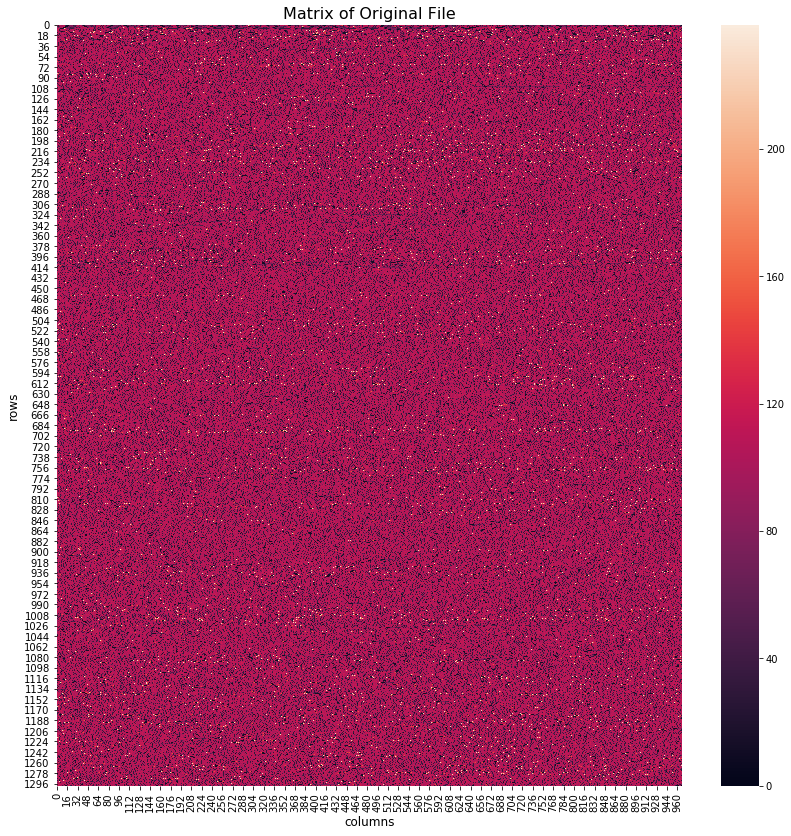

In [19]:
# Create and plot original matrix
row_len = 1300
col_len = 967
ori_matrix = create_byte_matrix(text_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of Original File')

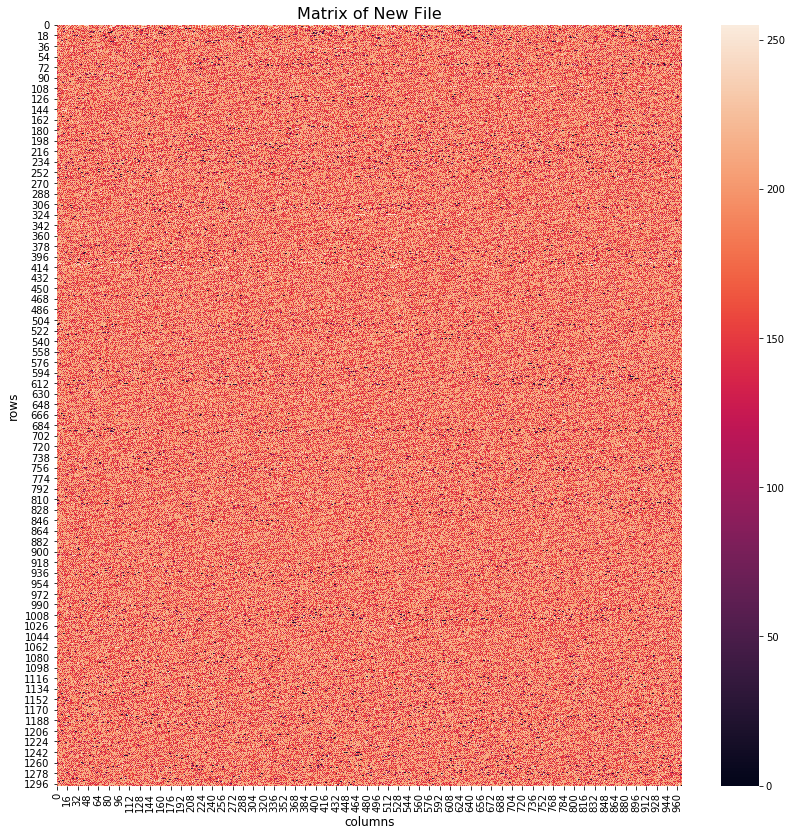

In [20]:
# Create and plot the new matrix (with low entropy)
row_len = 1300
col_len = 967
ori_matrix = create_byte_matrix(best_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of New File')

In [21]:
# Save the new file as txt
temp_file_path = file_path.replace('.txt', '-new.txt')
with open(temp_file_path, 'w+b') as f:
    binary_format = bytearray(best_byte_list)
    f.write(binary_format)

### Theoretical compression percentage

In [22]:
# Calculating new theoretical compression percentage
compress_rate = calc_compression_percentage(actual_entropy, best_option['entropy'])
print(compress_rate, '%')

-14.85267573158105 %


## 3. Restoring Entropy to Decompression

Below, the functions that allow you to reverse the entropy change.

In [23]:
# Restoring entropy process
def restore_entropy(byte_list, neighborhood, key):
    new_byte_list = []
    n = len(byte_list)
    
    for i in range(n - 1, -1, -1):
        curr_value = byte_list[i] ^ key
            
        for j in range(i - neighborhood, i + neighborhood + 1):
            if j < i and j >= 0:
                # Backward
                curr_value = curr_value ^ byte_list[j]
            elif j > i and j < n:
                # Forward
                curr_value = curr_value ^ new_byte_list[n - j - 1]
        
        new_byte_list.append(curr_value)
    
    # Return reservsed list
    return list(reversed(new_byte_list))

In [24]:
# Call the entropy restoration function
new_byte_list = restore_entropy(best_byte_list, neighborhood, best_option['key'])

#### Validation

In [25]:
# Comparing size of byte lists
len(new_byte_list) == len(text_byte_list)

True

In [26]:
# Comparing values of byte lists
sum(new_byte_list) - sum(text_byte_list)

0

In [27]:
# Comparing entropies of byte lists
entropy_shannon(text_byte_list, 2) == entropy_shannon(new_byte_list, 2)

True

#### Plotting

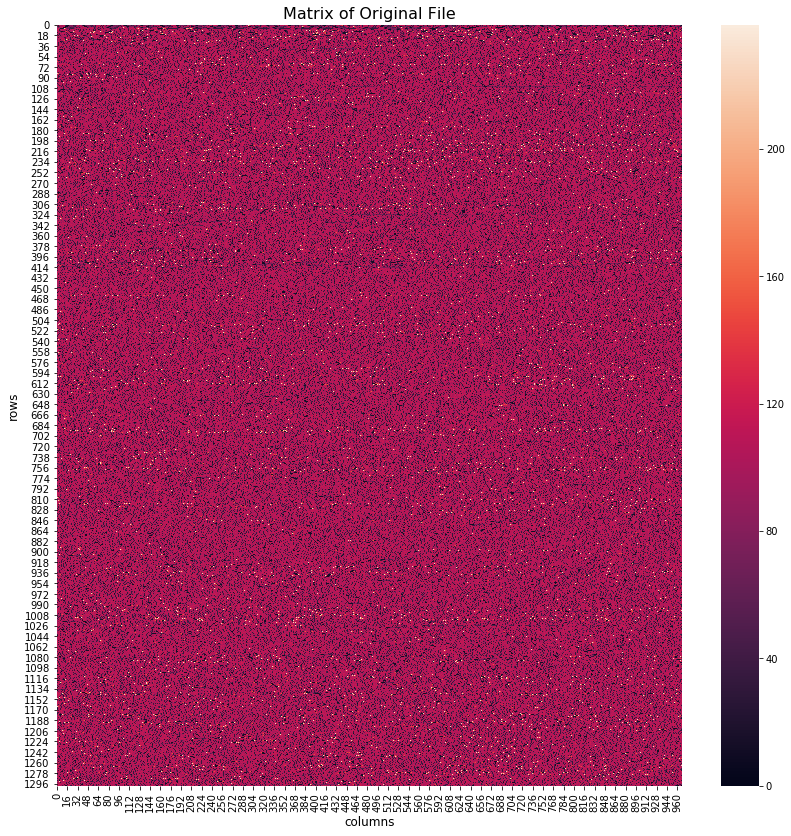

In [28]:
# Create and plot the new matrix (with low entropy)
row_len = 1300
col_len = 967
ori_matrix = create_byte_matrix(new_byte_list, row_len, col_len)
plot_byte_matrix(ori_matrix, 'Matrix of Original File')

In [29]:
# Save the original file as txt
temp_file_path = file_path.replace('.txt', '-original.txt')
with open(temp_file_path, 'w+b') as f:
    binary_format = bytearray(new_byte_list)
    f.write(binary_format)

## References

<a name='#link_one' href='https://en.wikipedia.org/wiki/Data_compression' target='_blank' >[1]</a> Wikipedia - Data Compression.  
<a name='#link_two' href='https://en.wikipedia.org/wiki/Entropy' target='_blank' >[2]</a> Wikipedia - Entropy.  

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>